In [1]:
import json
import time
import pandas as pd
from IPython.display import clear_output
from datetime import datetime
import numpy as np
import websocket
# Initialize a list to store all incoming messages
orderbook_rows = []

from datetime import datetime

def process_orderbook_message(data, ts):
    current_time_ms = int(time.time() * 1000)  # Convert to ms
    latency = current_time_ms - ts
    
    ts_human_readable = datetime.utcfromtimestamp(ts/1000).strftime('%H:%M:%S.%f')[:-3]  # Format avec millisecondes

    # Correction des lignes suivantes
    best_bid_price = float(data['b'][0][0]) if data['b'] else None
    best_bid_quantity = float(data['b'][0][1]) if data['b'] else 0
    best_ask_price = float(data['a'][0][0]) if data['a'] else None
    best_ask_quantity = float(data['a'][0][1]) if data['a'] else 0
    
    # Calculate imbalance
    imbalance = best_bid_quantity - best_ask_quantity

    # Create a dictionary to store the data
    new_row = {
        "Timestamp": ts_human_readable,
        "Symbol": data["s"],
        "UpdateID": data["u"],
        "CrossSeq": data["seq"],
        "BestBidPrice": best_bid_price,
        "BestBidQuantity": best_bid_quantity,
        "BestAskPrice": best_ask_price,
        "BestAskQuantity": best_ask_quantity,
        "Latency": latency,
    }

    orderbook_rows.append(new_row)



def on_message(ws, message):
    clear_output(wait=True)
    message_dict = json.loads(message)
    if message_dict["topic"] == "orderbook.1.BTCUSDT":
        ts = message_dict["ts"]
        process_orderbook_message(message_dict["data"], ts)

def on_open(ws):
    subscribe_msg = {"op": "subscribe", "args": ["orderbook.1.BTCUSDT"]}
    ws.send(json.dumps(subscribe_msg))

url = "wss://stream.bybit.com/v5/public/linear"
ws = websocket.WebSocketApp(
    url,
    on_message=on_message,
    on_open=on_open
)

ws.run_forever()

False

In [2]:
import numpy as np
import pandas as pd


# Convert the list of rows to a DataFrame after you stop the WebSocket
df = pd.DataFrame(orderbook_rows)
# Forward fill NaN values
df.fillna(method='ffill', inplace=True)
# Calculate additional columns based on the provided data
df

,Timestamp,Symbol,UpdateID,CrossSeq,BestBidPrice,BestBidQuantity,BestAskPrice,BestAskQuantity,Latency
0,00:56:51.728,BTCUSDT,38503866,87641068372,27317.9,3.673,27318.0,40.444,438
1,00:56:51.787,BTCUSDT,38503867,87641068514,27317.9,3.639,27318.0,0.000,383
2,00:56:51.837,BTCUSDT,38503868,87641068612,27317.9,3.675,27318.0,0.000,337
3,00:56:52.017,BTCUSDT,38503869,87641068969,27317.9,4.064,27318.0,0.000,161
4,00:56:52.088,BTCUSDT,38503870,87641069120,27317.9,0.000,27318.0,40.344,122
...,...,...,...,...,...,...,...,...,...
55023,01:43:12.087,BTCUSDT,38558889,87649891432,27297.0,0.000,27297.1,6.833,123
55024,01:43:12.118,BTCUSDT,38558890,87649891453,27297.0,21.620,27297.1,0.000,122
55025,01:43:12.418,BTCUSDT,38558891,87649891548,27297.0,21.470,27297.1,0.000,122
55026,01:43:12.557,BTCUSDT,38558892,87649891608,27297.0,0.000,27297.1,7.833,123


In [29]:
#Spread
df['Spread'] = df['BestAskPrice'] - df['BestBidPrice']

#Spread percent
df['SpreadPercent'] = ((df['BestAskPrice'] - df['BestBidPrice']) / df['BestAskPrice']) * 100

#MidPrice
df['MidPrice'] = (df['BestAskPrice'] + df['BestBidPrice']) / 2

#OrderBook Imbalance
df['Imbalance'] = df['BestBidQuantity'] - df['BestAskQuantity']

#BidAsk Ratio
df['BidAskRatio'] = np.where(df['BestAskQuantity'] != 0, df['BestBidQuantity'] / df['BestAskQuantity'], np.nan)

#Volume Imbalance
df['VolumeImbalance'] = (df['BestBidQuantity'] / (df['BestBidQuantity'] + df['BestAskQuantity'])) * 100

#Log return
df['LogReturn'] = np.log(df['MidPrice'] / df['MidPrice'].shift(1))
df['LogReturn'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['LogReturn'].fillna(0, inplace=True)


#Price Volatility
df['PriceVolatility'] = df['MidPrice'].rolling(window=10).std()

#HistoricalVolatility
df['HistoricalVolatility'] = df['LogReturn'].rolling(window=10).std() * np.sqrt(252)

#Price Momentum
df['PriceMomentum'] = df['MidPrice'].diff()

#ROC mesure du momentum
df['ROC'] = ((df['MidPrice'] - df['MidPrice'].shift(10)) / df['MidPrice'].shift(10)) * 100

#Ecart type Mobile
df['RollingSTD_10'] = df['MidPrice'].rolling(window=10).std()

#Delta Prix 
df['PriceDeltaPercent'] = df['MidPrice'].pct_change() * 100

#Simple return
df['SimpleReturn'] = df['MidPrice'].pct_change()


#SMA50
x=50
df['SMA_50'] = df['MidPrice'].rolling(window=x).mean()

#EMA20
df['EMA_20'] = df['MidPrice'].ewm(span=20, adjust=False).mean()

#RSI
delta = df['MidPrice'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = np.where(avg_loss != 0, avg_gain / avg_loss, 0)
df['RSI'] = 100 - (100 / (1 + rs))

short_ema = df['MidPrice'].ewm(span=12, adjust=False).mean()
long_ema = df['MidPrice'].ewm(span=26, adjust=False).mean()
df['MACD'] = short_ema - long_ema
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

#CumulativeOrderFlow
df['CumulativeOrderFlow'] = df['Imbalance'].cumsum()

#Stochasitc Oscillator
high14 = df['MidPrice'].rolling(14).max()
low14 = df['MidPrice'].rolling(14).min()
df['%K'] = (df['MidPrice'] - low14) / (high14 - low14) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

#Money Flow Index FMI
tp = (df['MidPrice'] + df['BestAskPrice'] + df['BestBidPrice']) / 3
rmf = tp * (df['BestBidQuantity'] + df['BestAskQuantity'])
delta = tp.diff()
pmf = pd.Series(np.where(delta > 0, rmf, 0), index=df.index)
nmf = pd.Series(np.where(delta < 0, rmf, 0), index=df.index)
mfr = pd.Series(np.where(nmf.rolling(14).sum() != 0, pmf.rolling(14).sum() / nmf.rolling(14).sum(), 0), index=df.index)
df['MFI'] = 100 - (100 / (1 + mfr))

#ATR mesure de la volatilité
tr = np.maximum(df['BestAskPrice'] - df['BestBidPrice'], 
                np.maximum(abs(df['BestAskPrice'] - df['MidPrice'].shift(1)), 
                           abs(df['BestBidPrice'] - df['MidPrice'].shift(1))))
df['ATR'] = tr.rolling(window=14).mean()


#remplacez les NaN et les infinis globalement
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [10]:
df

,Timestamp,Symbol,UpdateID,CrossSeq,BestBidPrice,BestBidQuantity,BestAskPrice,BestAskQuantity,Latency,Spread,...,SMA_50,EMA_20,RSI,MACD,MACD_Signal,CumulativeOrderFlow,%K,%D,MFI,ATR
0,00:56:51.728,BTCUSDT,38503866,87641068372,27317.9,3.673,27318.0,40.444,438,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-36.771,0.0,0.0,0.0,0.0
1,00:56:51.787,BTCUSDT,38503867,87641068514,27317.9,3.639,27318.0,0.000,383,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-33.132,0.0,0.0,0.0,0.0
2,00:56:51.837,BTCUSDT,38503868,87641068612,27317.9,3.675,27318.0,0.000,337,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-29.457,0.0,0.0,0.0,0.0
3,00:56:52.017,BTCUSDT,38503869,87641068969,27317.9,4.064,27318.0,0.000,161,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-25.393,0.0,0.0,0.0,0.0
4,00:56:52.088,BTCUSDT,38503870,87641069120,27317.9,0.000,27318.0,40.344,122,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-65.737,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55023,01:43:12.087,BTCUSDT,38558889,87649891432,27297.0,0.000,27297.1,6.833,123,0.1,...,27297.05,27297.05,0.0,-1.555964e-08,-2.288309e-08,-283905.084,0.0,0.0,0.0,0.1
55024,01:43:12.118,BTCUSDT,38558890,87649891453,27297.0,21.620,27297.1,0.000,122,0.1,...,27297.05,27297.05,0.0,-1.440640e-08,-2.118775e-08,-283883.464,0.0,0.0,0.0,0.1
55025,01:43:12.418,BTCUSDT,38558891,87649891548,27297.0,21.470,27297.1,0.000,122,0.1,...,27297.05,27297.05,0.0,-1.334047e-08,-1.961830e-08,-283861.994,0.0,0.0,0.0,0.1
55026,01:43:12.557,BTCUSDT,38558892,87649891608,27297.0,0.000,27297.1,7.833,123,0.1,...,27297.05,27297.05,0.0,-1.235094e-08,-1.816482e-08,-283869.827,0.0,0.0,0.0,0.1


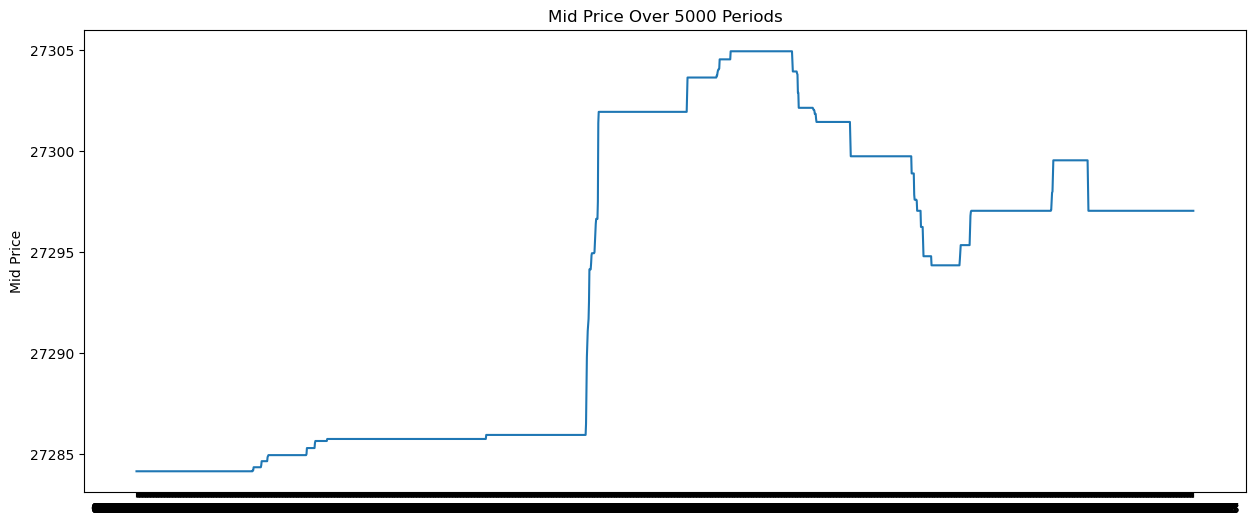

In [26]:
df_5000 = df.iloc[-2500:]  # Prend les 5000 dernières lignes

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df_5000['Timestamp'], df_5000['MidPrice'])
plt.title('Mid Price Over 5000 Periods')
plt.ylabel('Mid Price')
plt.show()


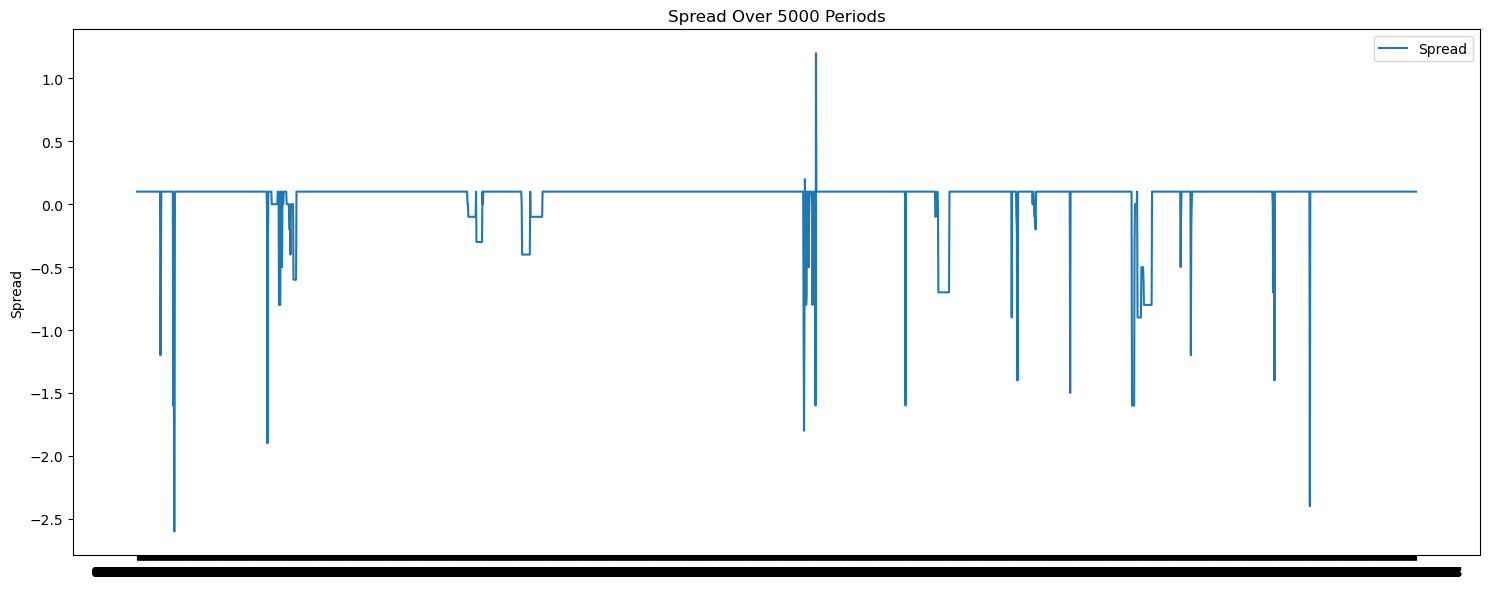

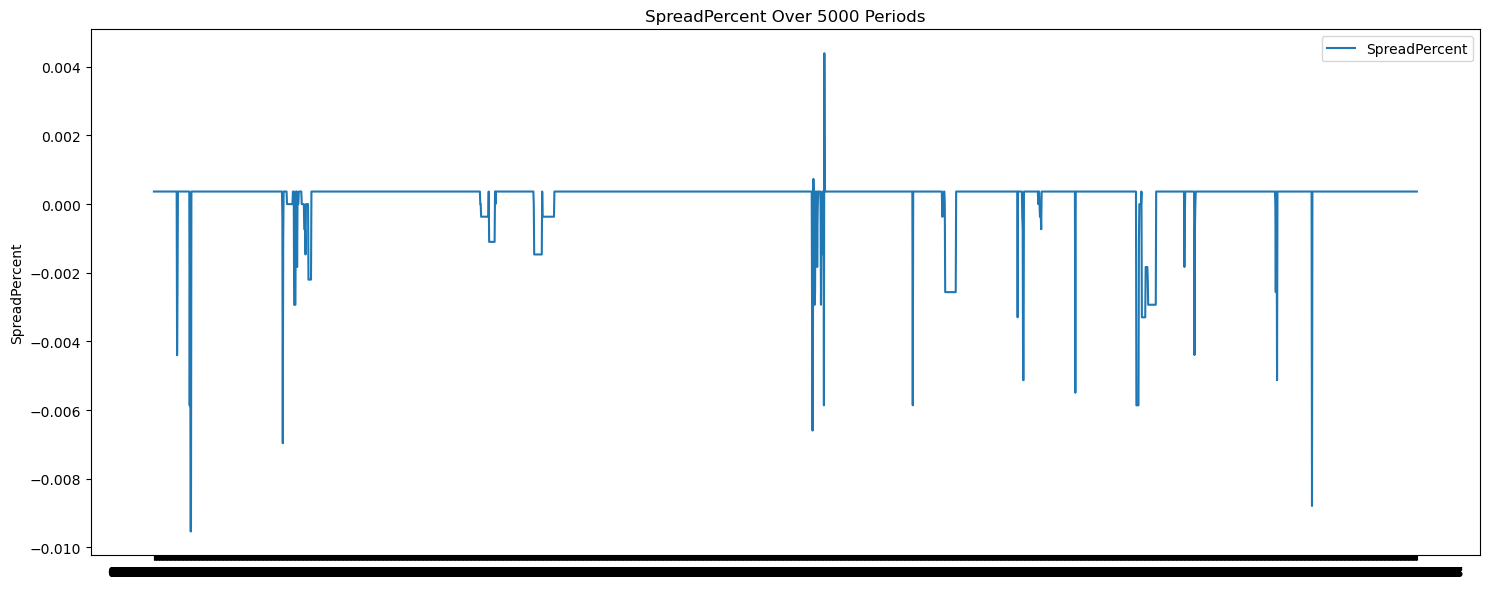

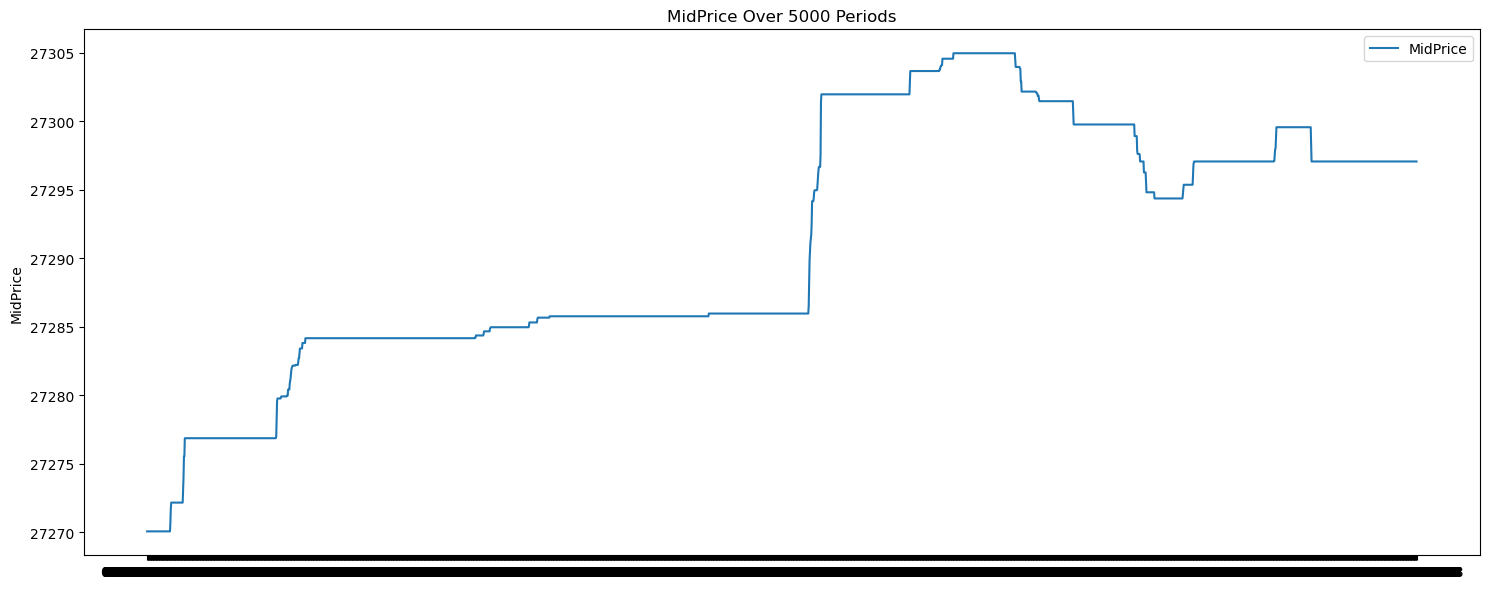

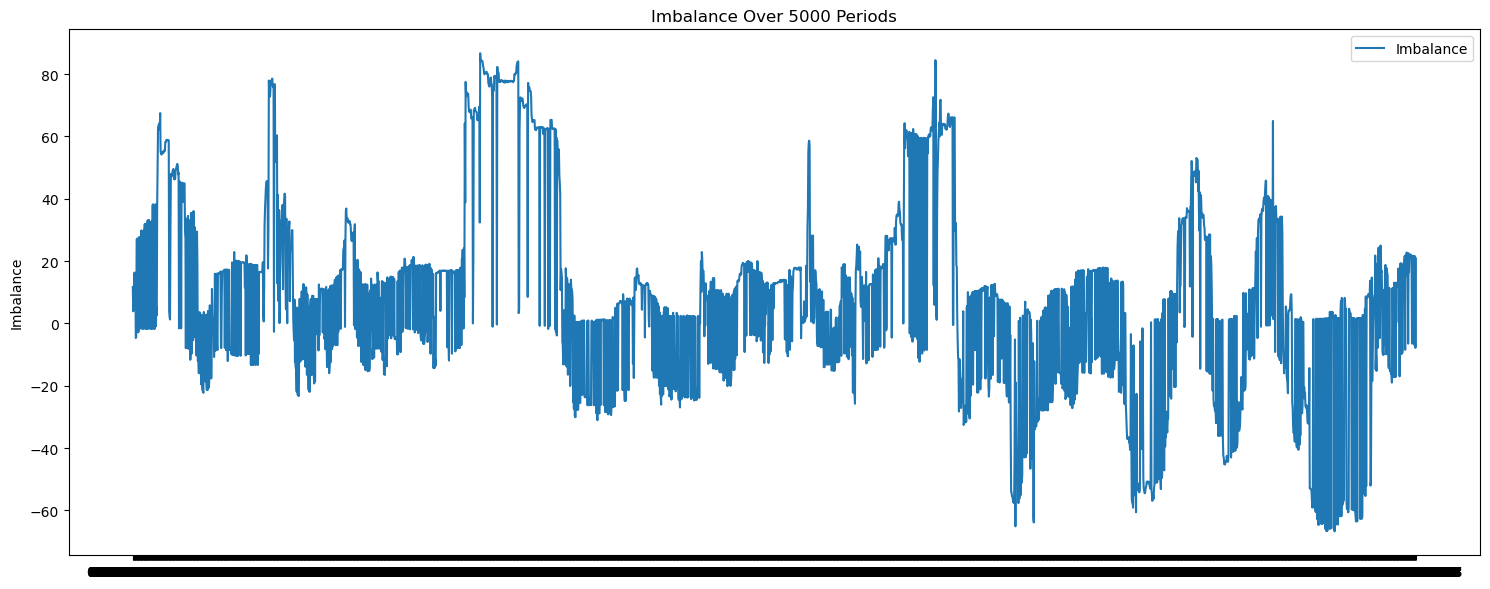

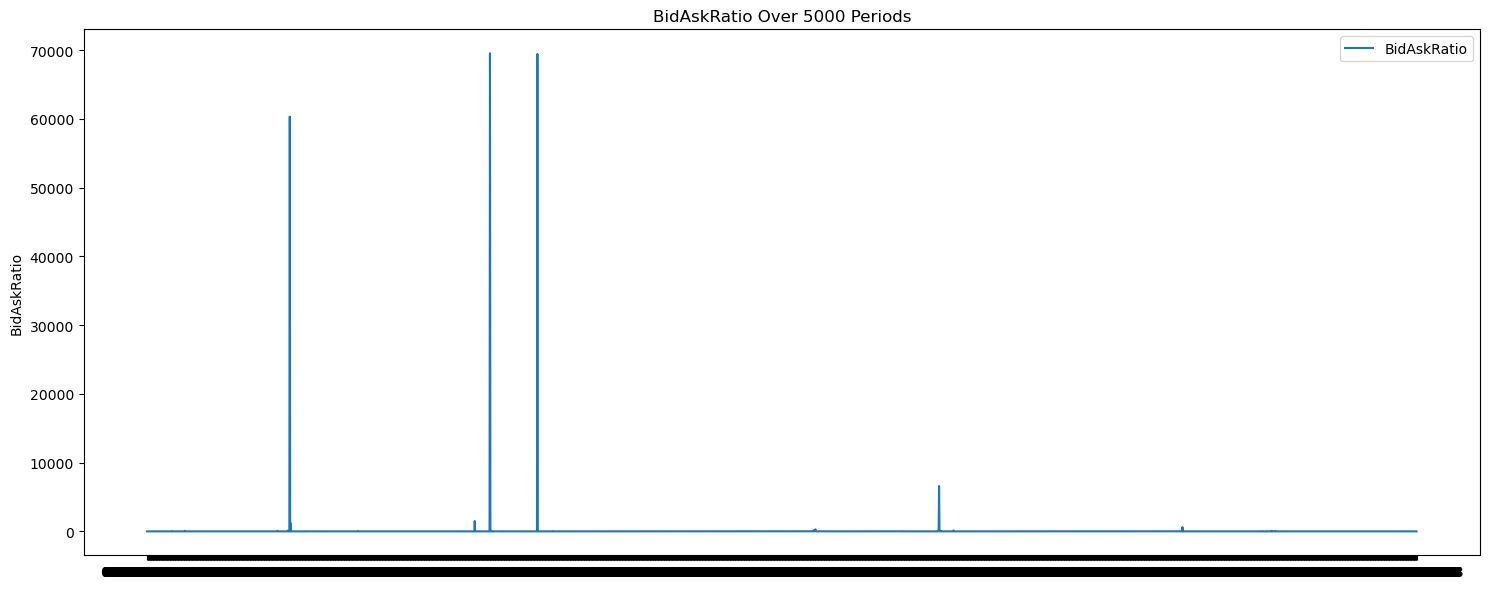

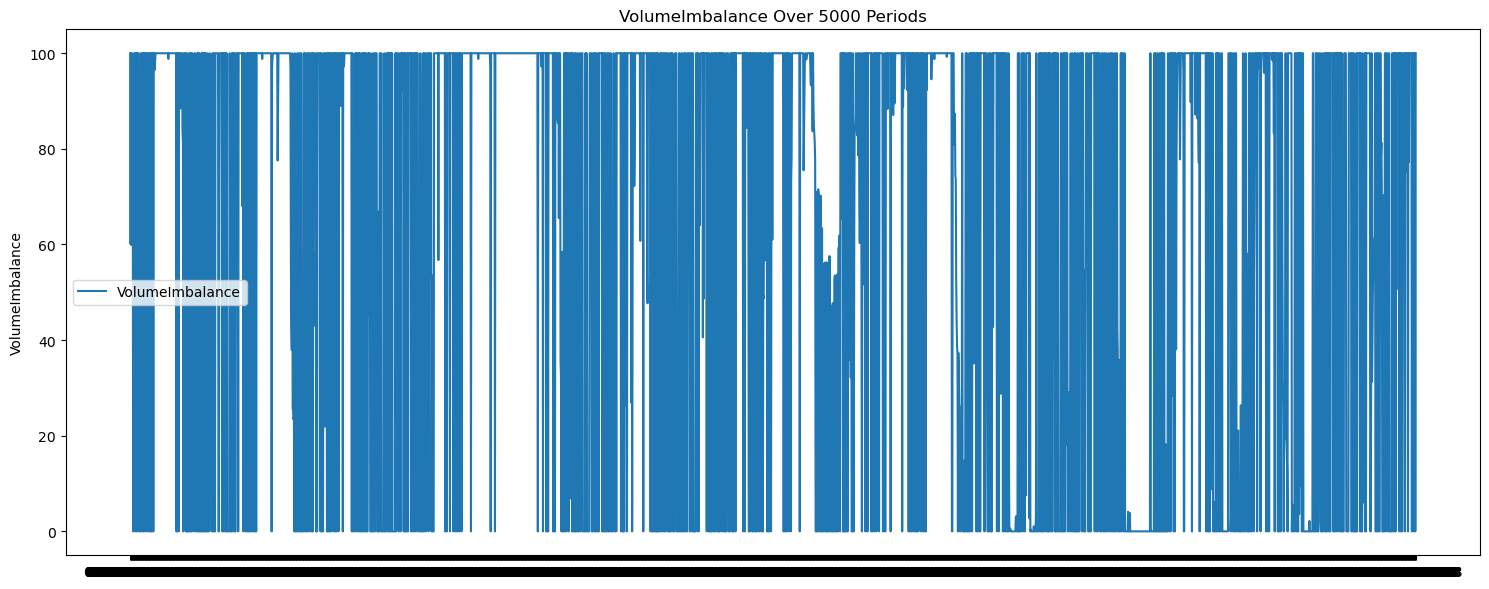

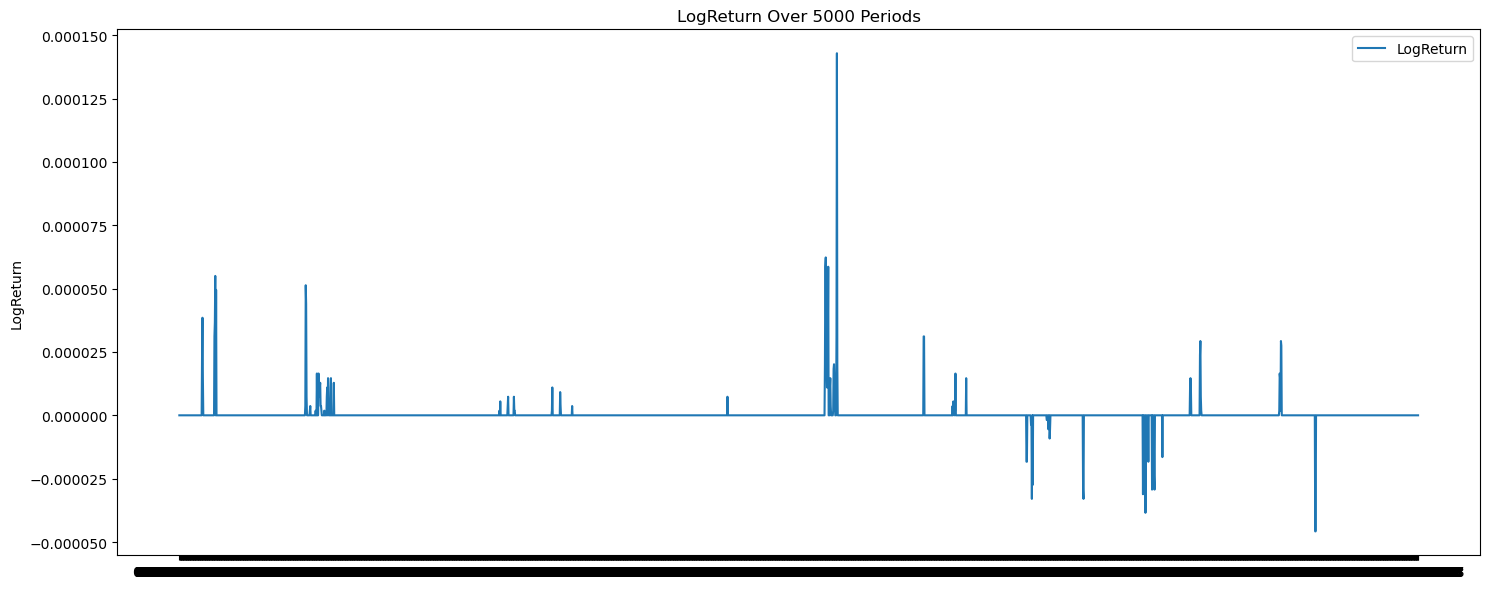

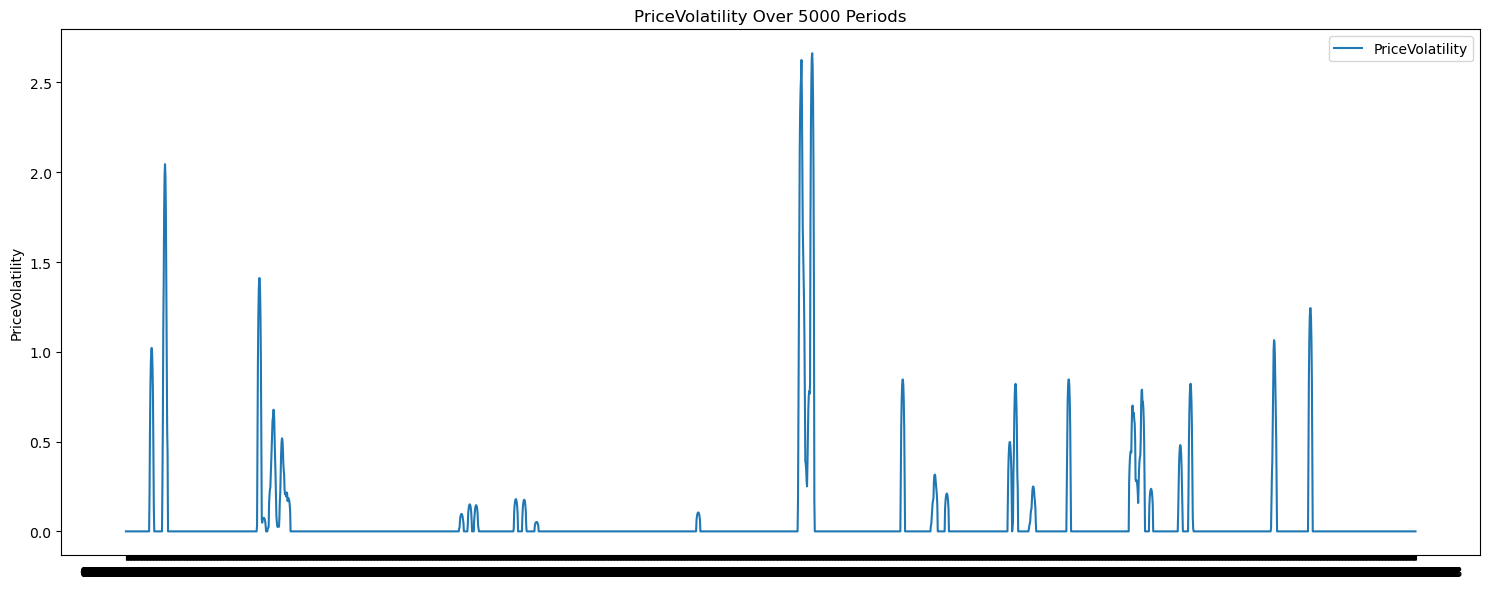

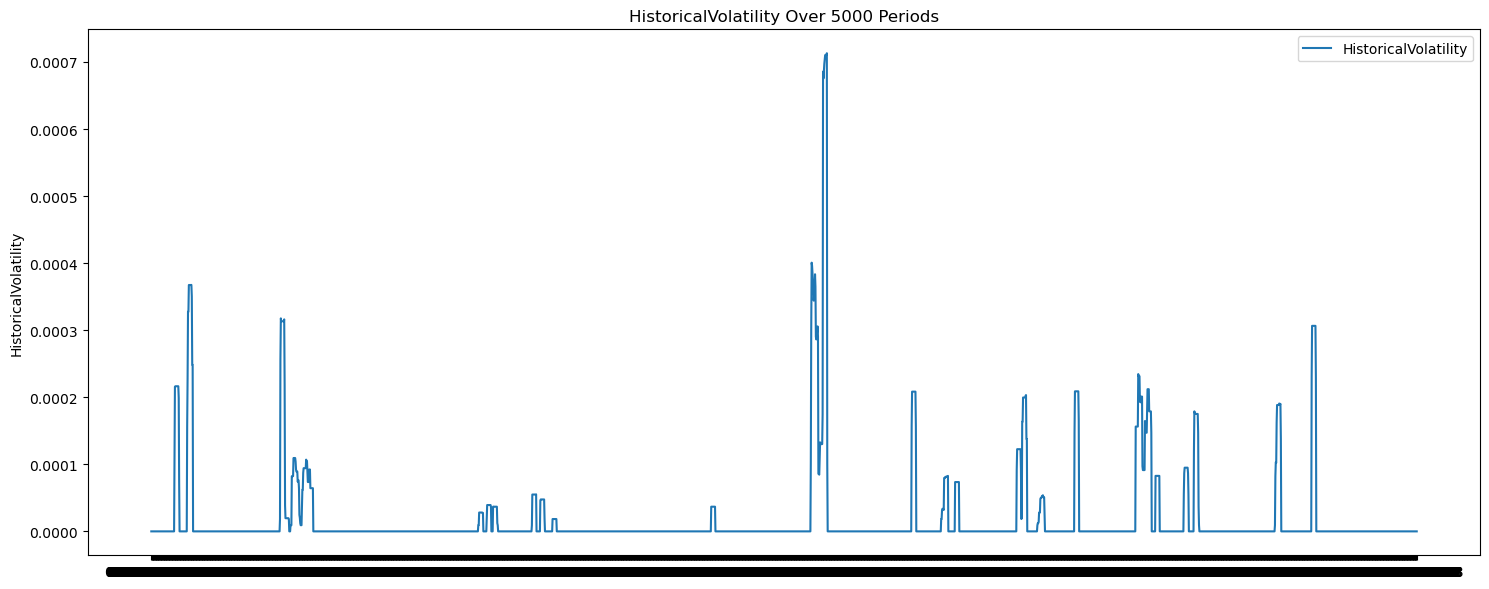

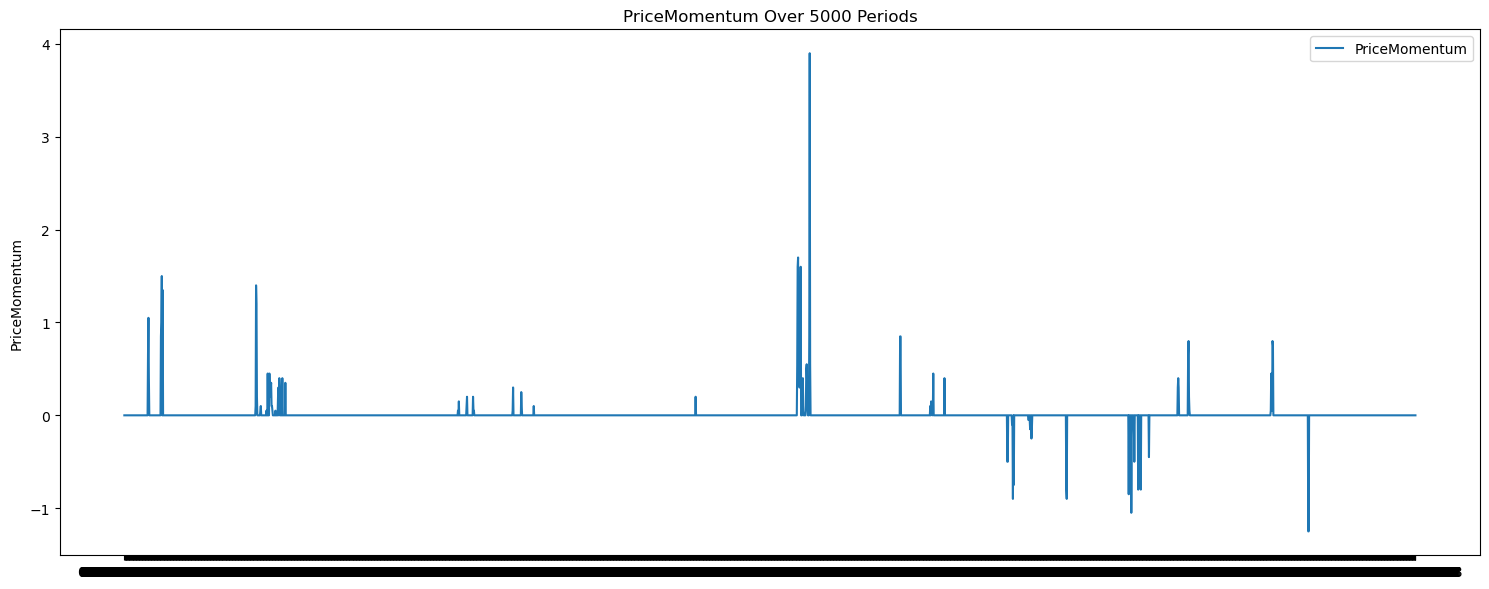

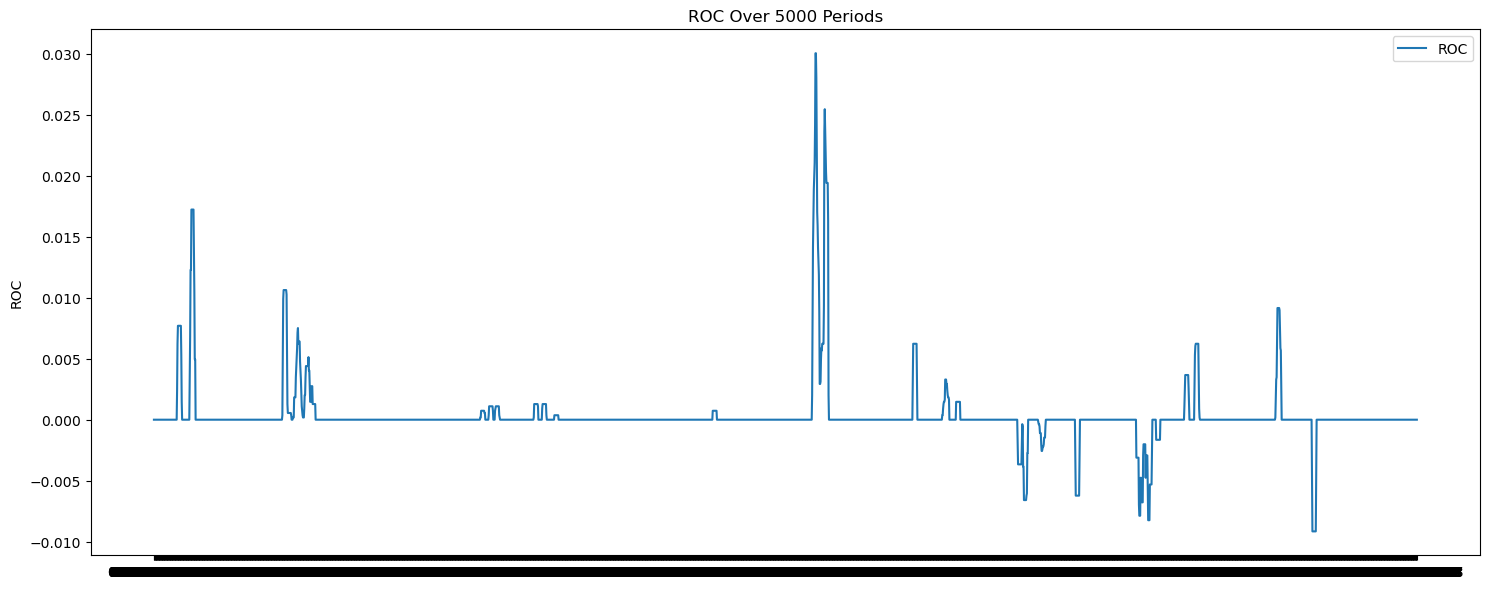

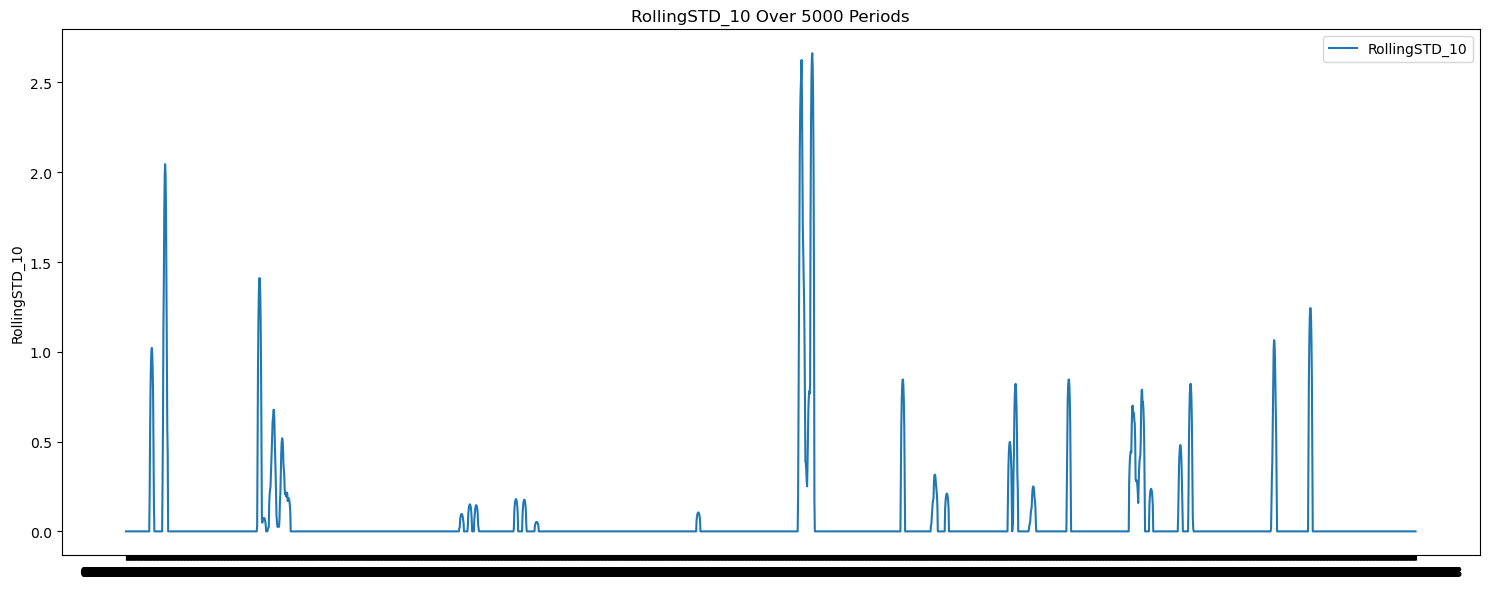

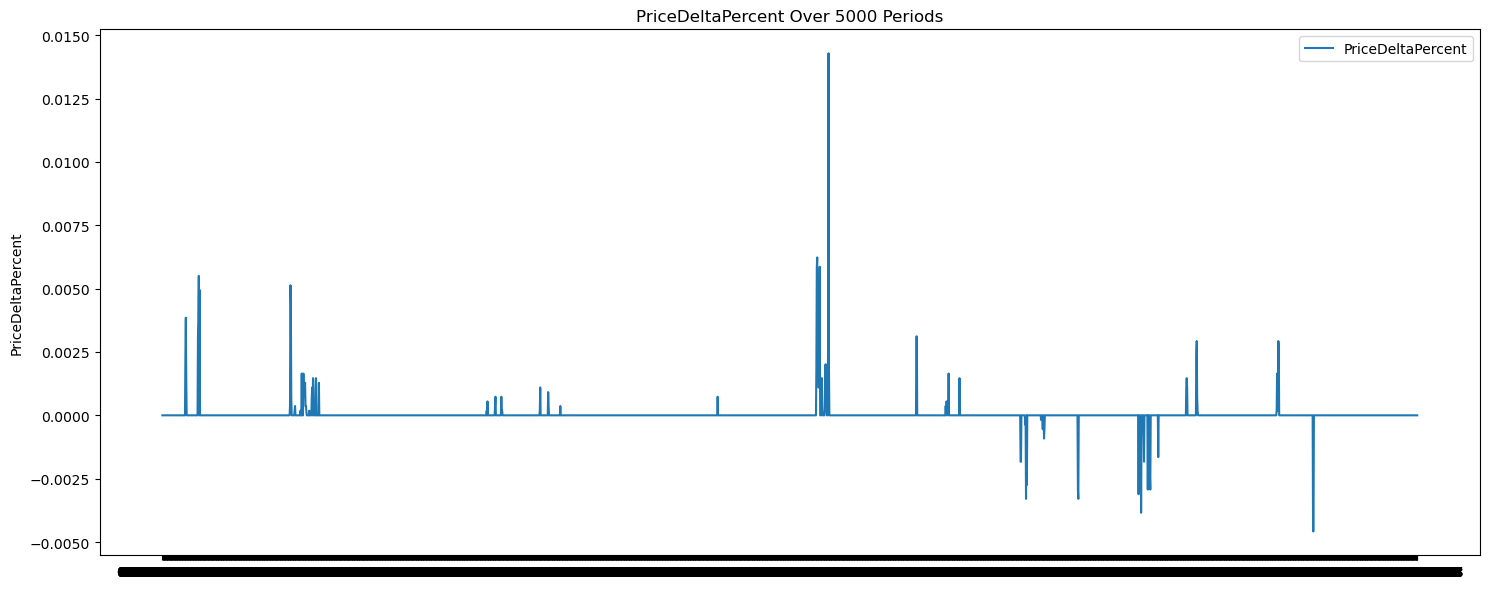

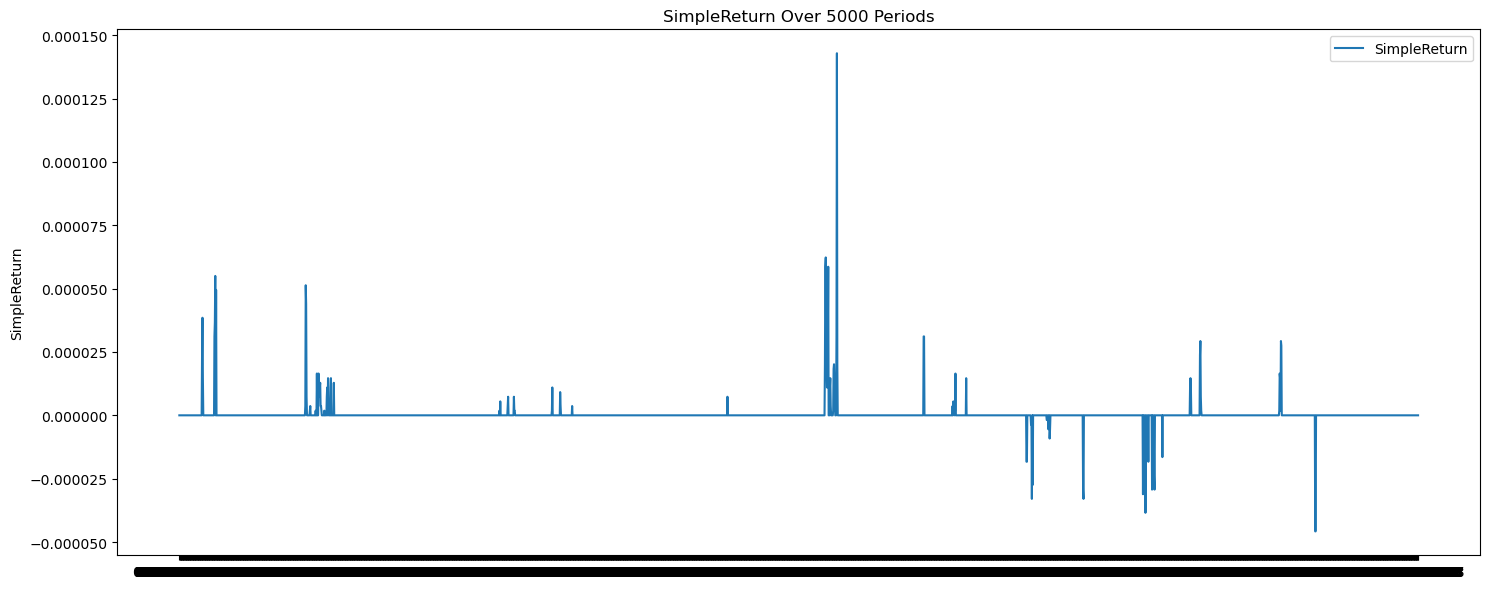

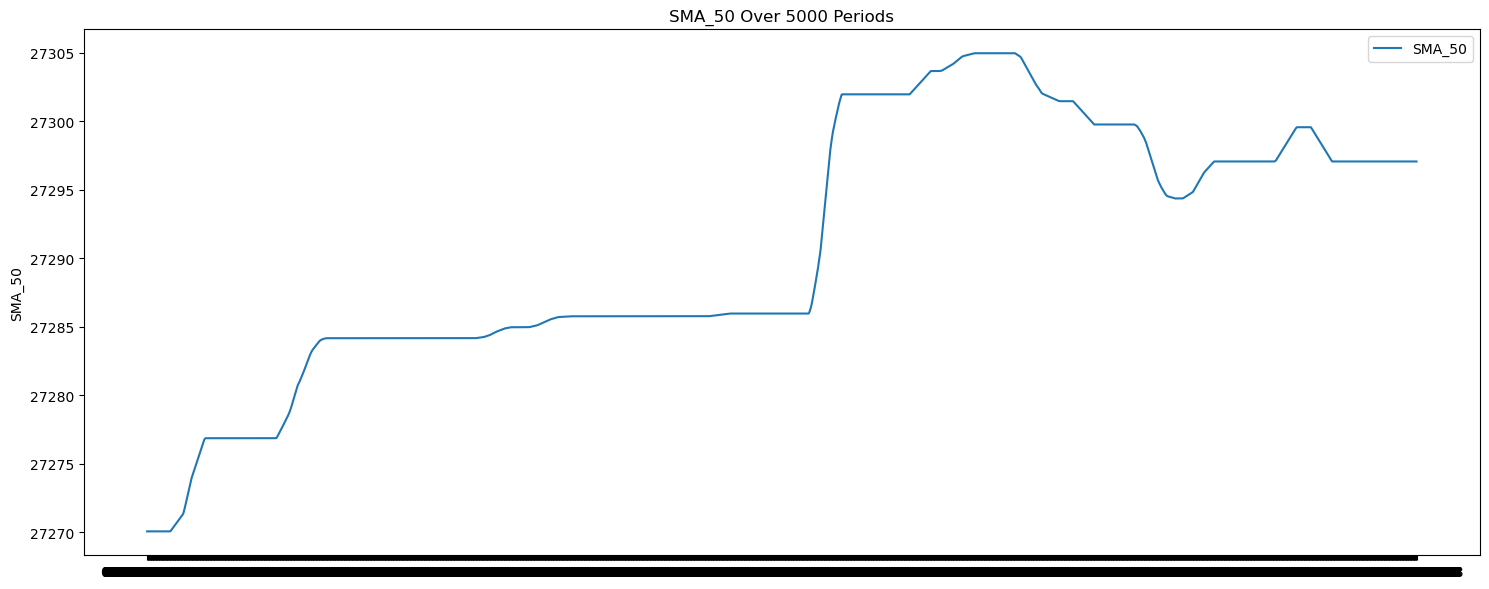

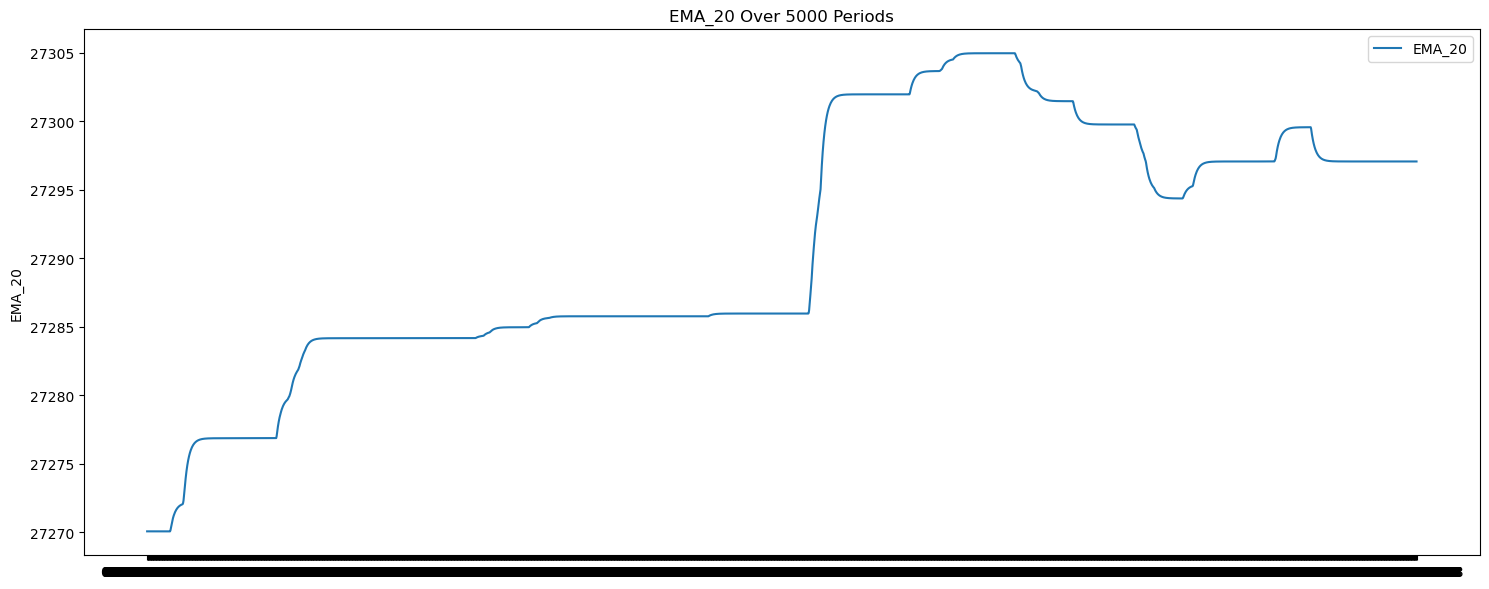

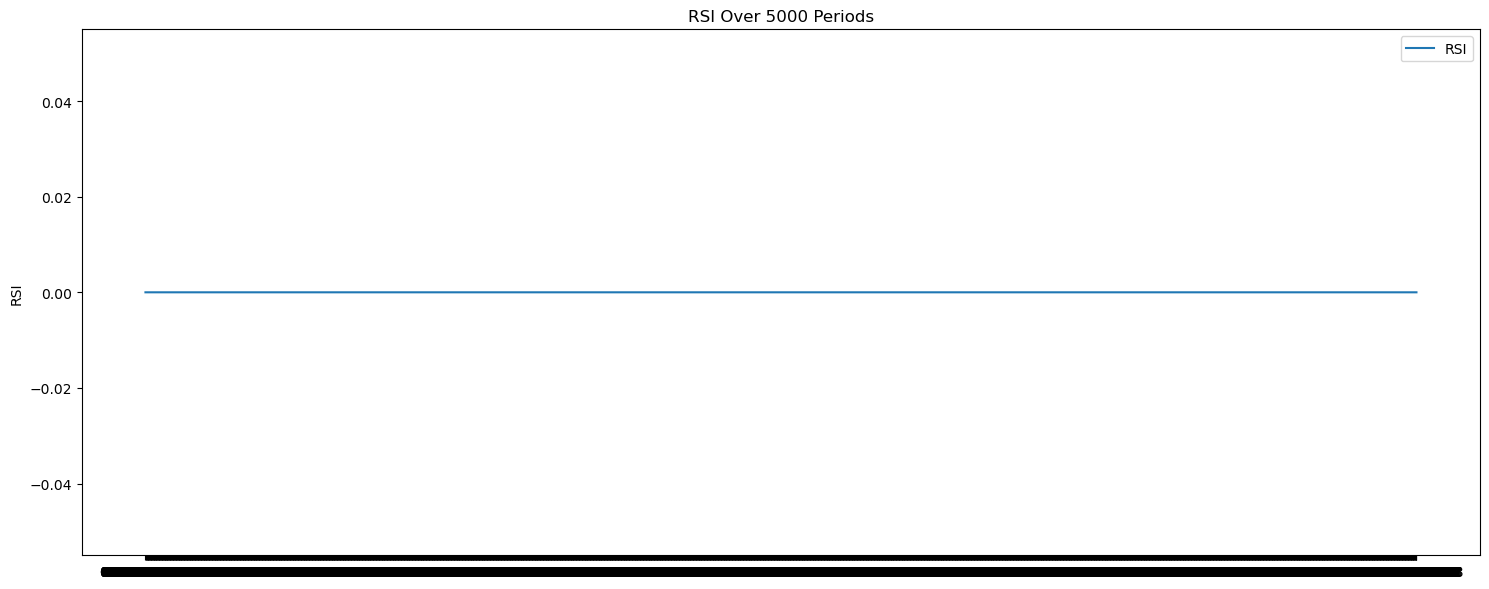

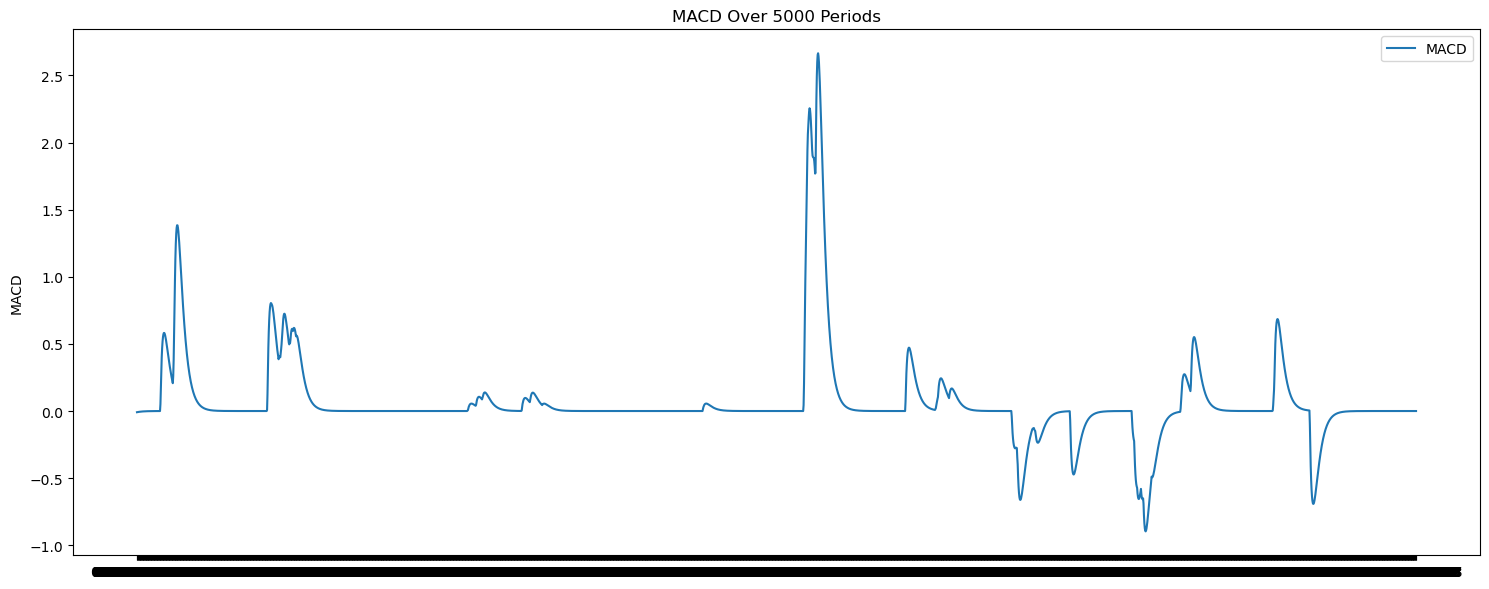

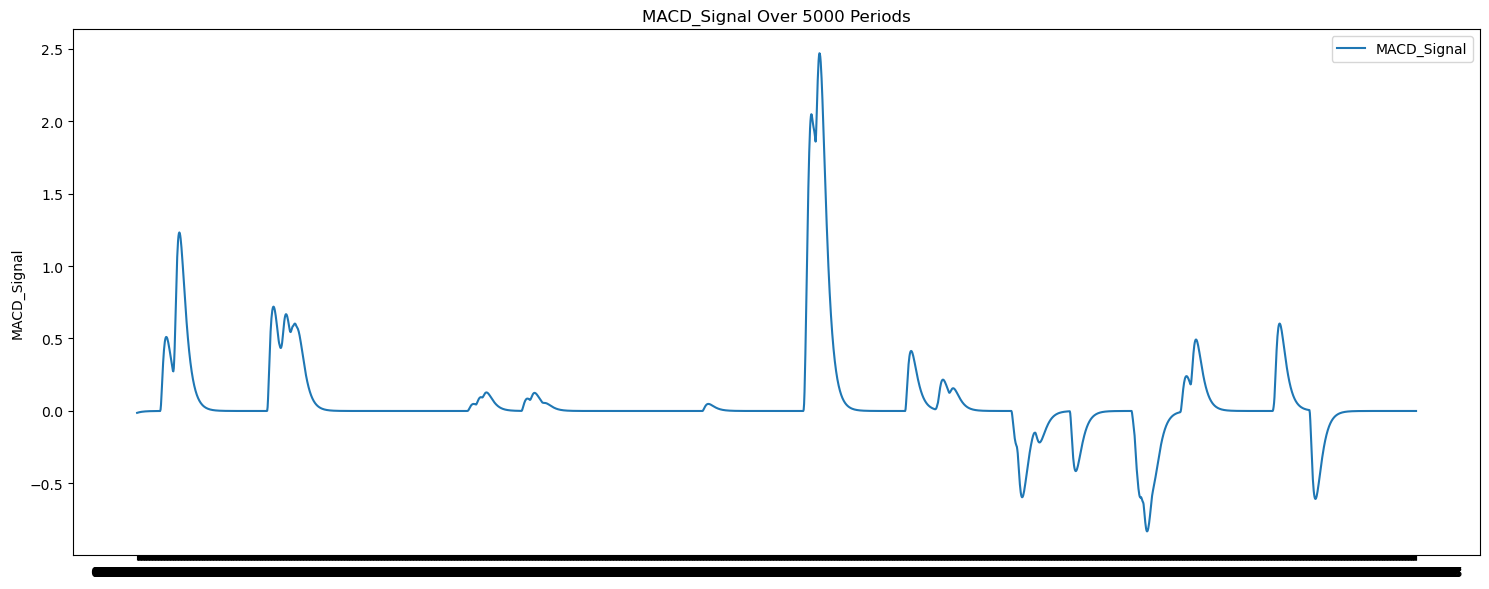

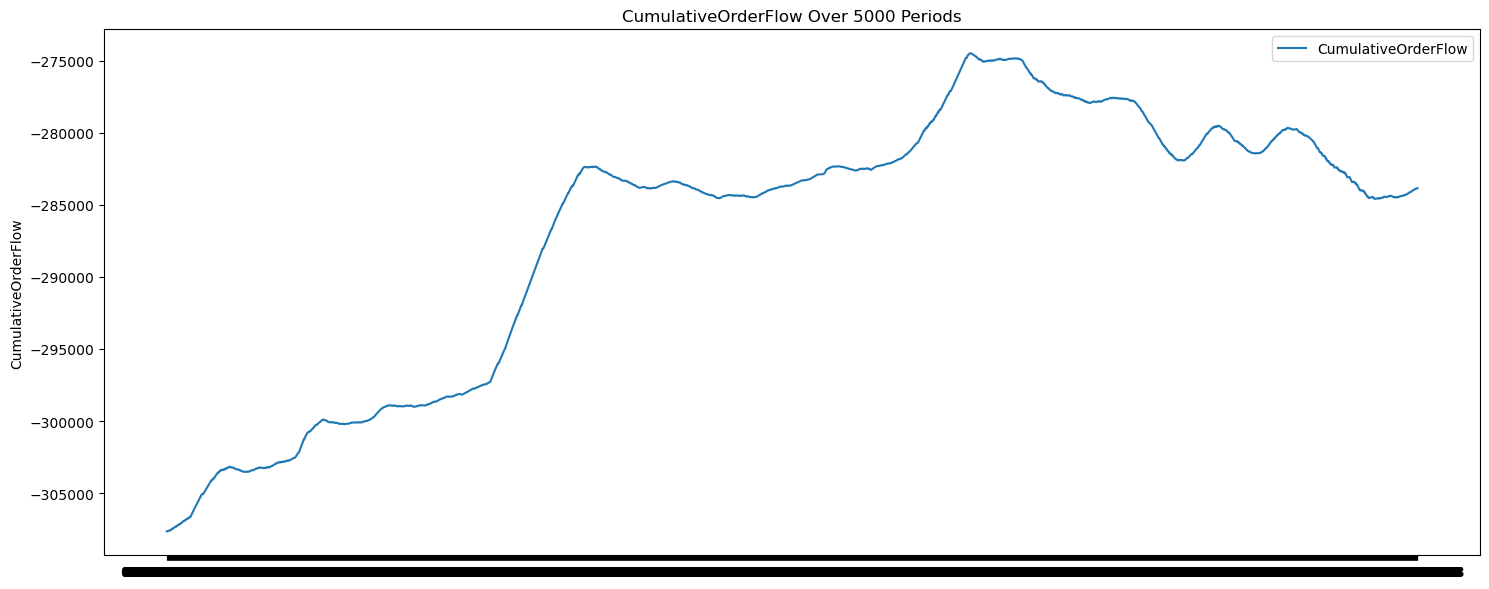

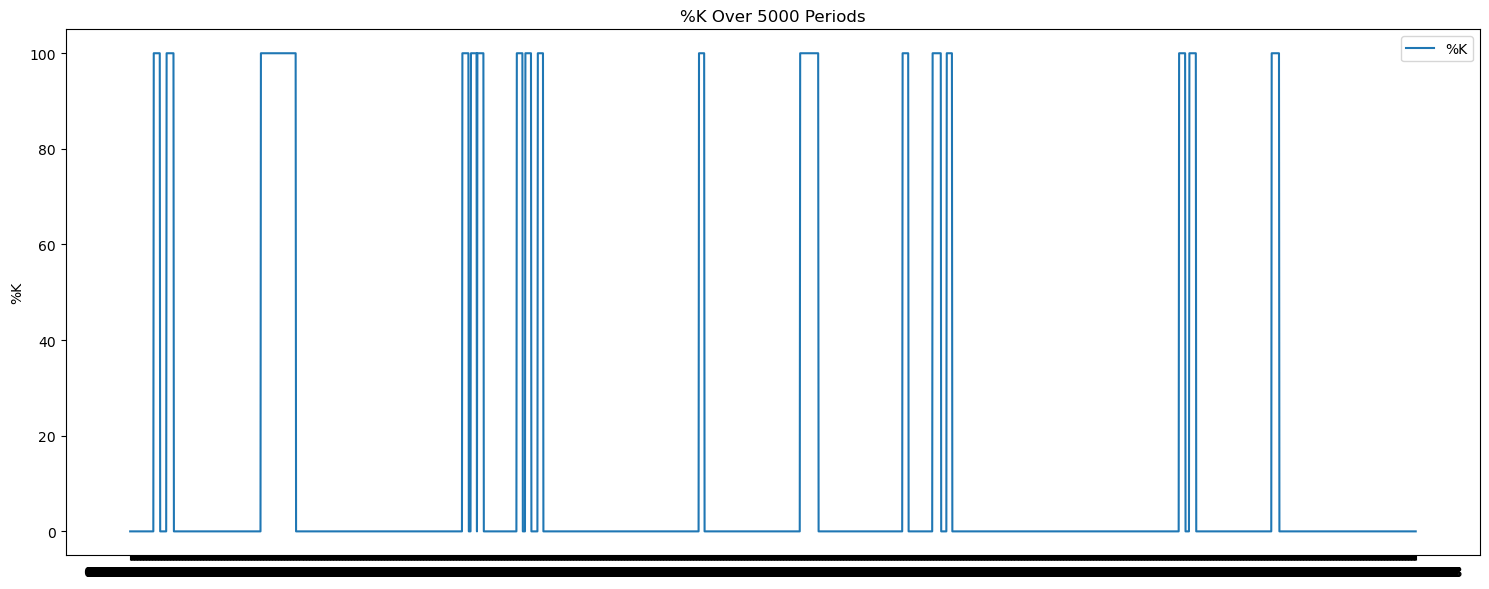

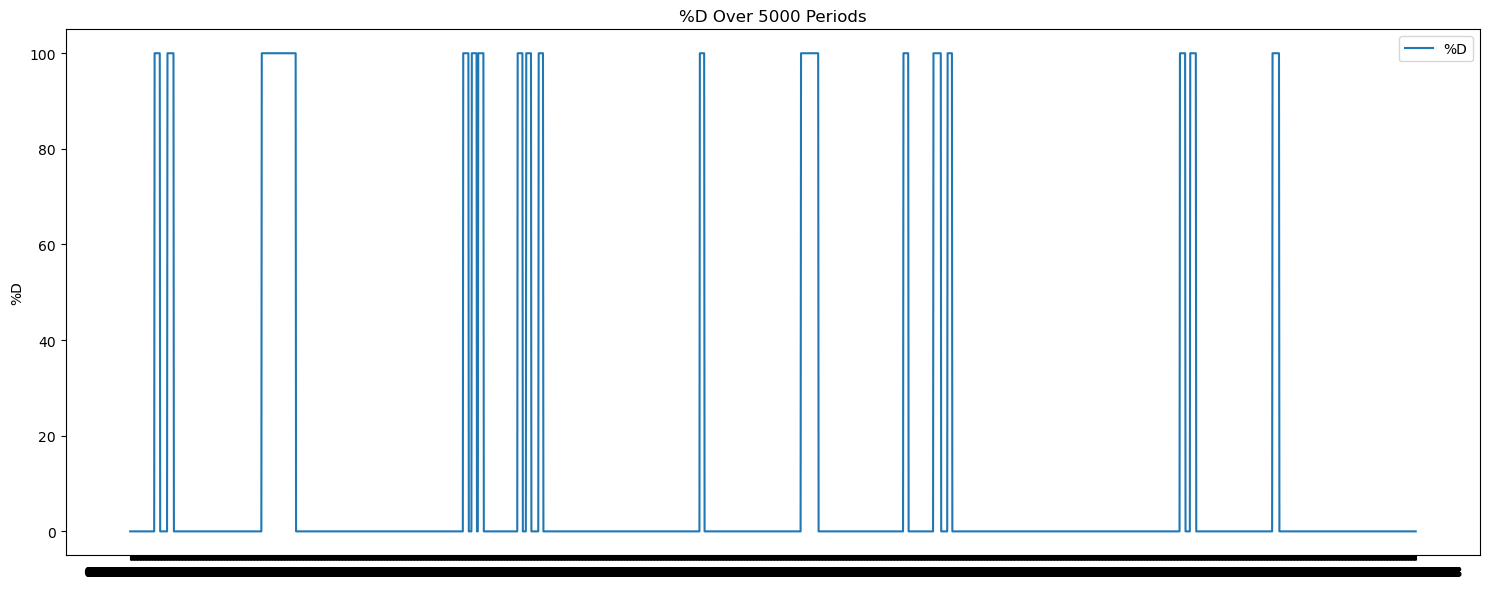

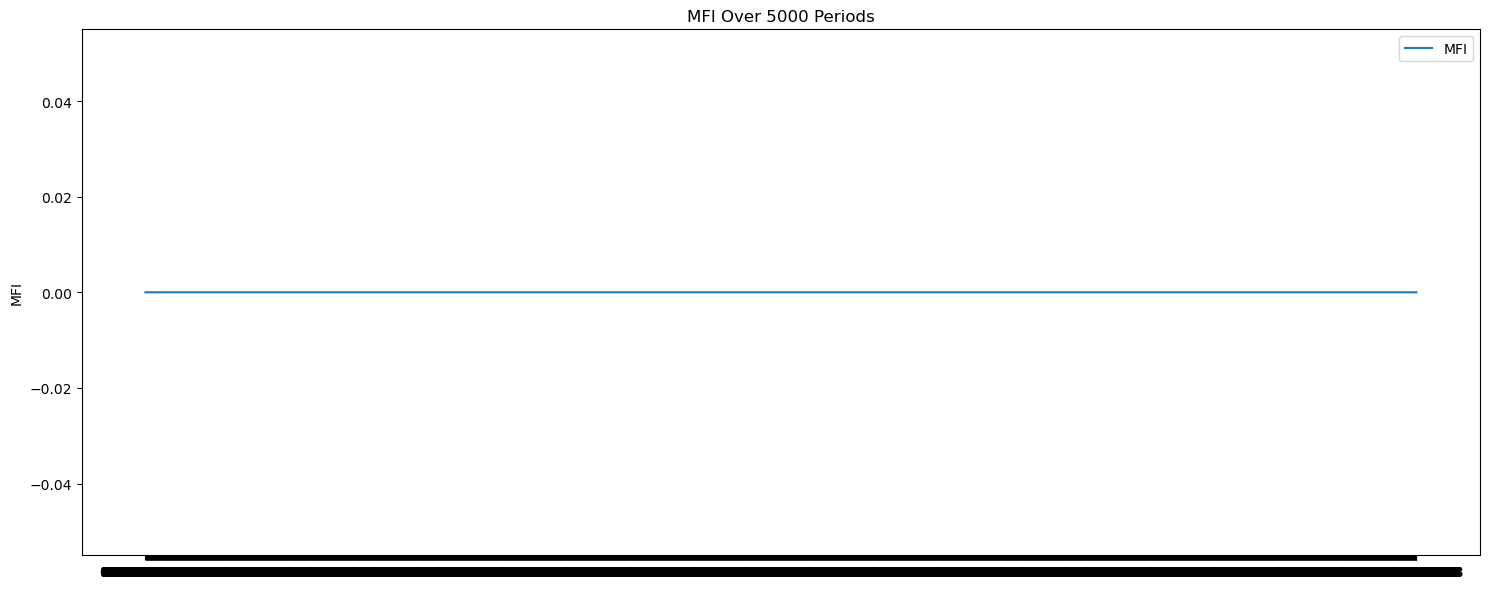

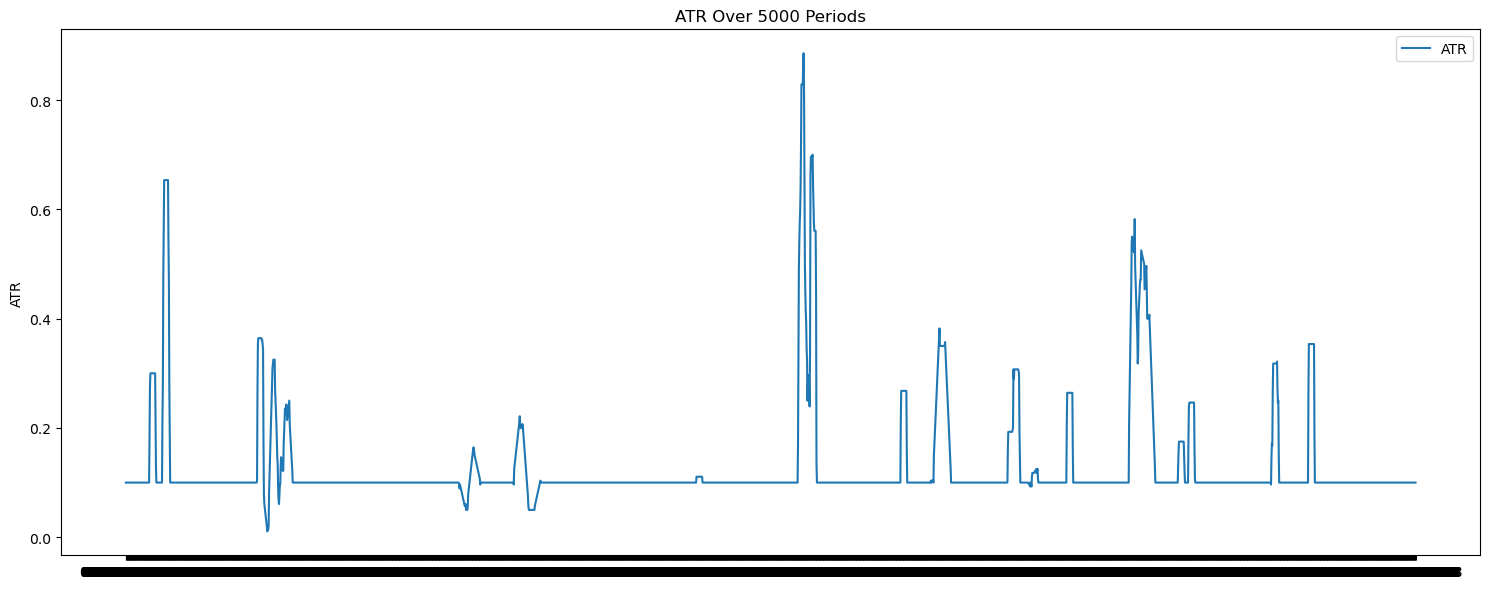

In [28]:
features = [
    'Spread', 'SpreadPercent', 'MidPrice', 'Imbalance', 'BidAskRatio', 'VolumeImbalance',
    'LogReturn', 'PriceVolatility', 'HistoricalVolatility', 'PriceMomentum', 'ROC',
    'RollingSTD_10', 'PriceDeltaPercent', 'SimpleReturn', 'SMA_50', 'EMA_20', 'RSI',
    'MACD', 'MACD_Signal', 'CumulativeOrderFlow', '%K', '%D', 'MFI', 'ATR'
]

df_5000 = df.iloc[-3000:]  # Prend les 5000 dernières lignes

for feature in features:
    plt.figure(figsize=(15, 6))
    plt.plot(df_5000['Timestamp'], df_5000[feature], label=feature)
    plt.title(f'{feature} Over 5000 Periods')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [30]:
df['Spread'] = df['BestAskPrice'] - df['BestBidPrice']


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000002BE762627A0> (for post_execute):


KeyboardInterrupt: 

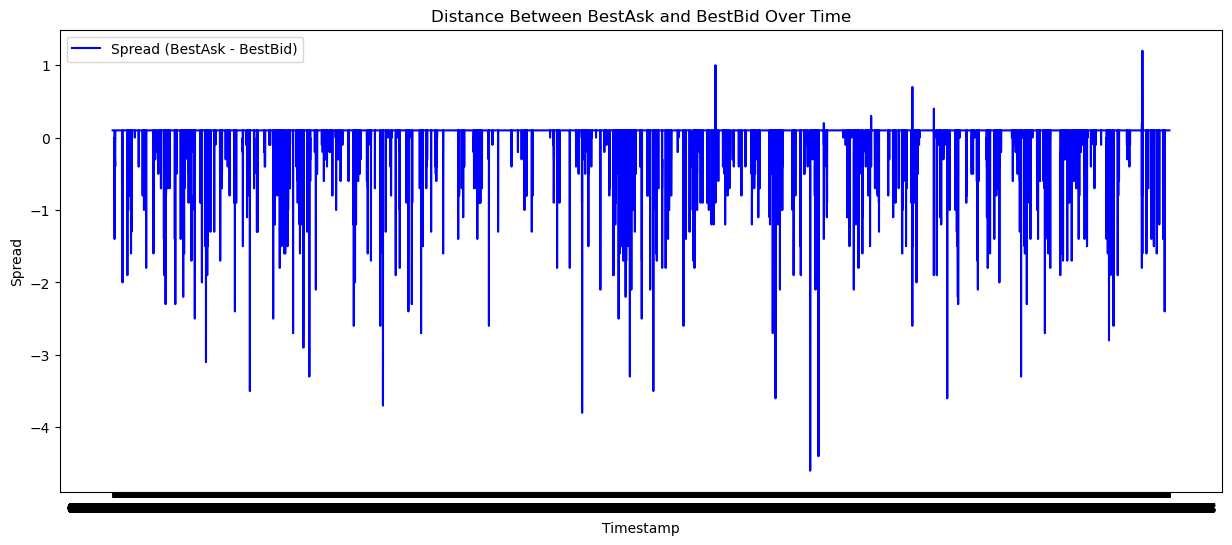

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(df['Timestamp'], df['Spread'], label='Spread (BestAsk - BestBid)', color='blue')
plt.title('Distance Between BestAsk and BestBid Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Spread')
plt.legend()
plt.tight_layout()
plt.show()


In [83]:
df_ia = df_ia.iloc[0:0]


In [84]:
df_ia

,Timestamp,Symbol,UpdateID,CrossSeq,BestBidPrice,BestBidQuantity,BestAskPrice,BestAskQuantity,Latency,Spread,...,EMA_20,RSI,MACD,MACD_Signal,CumulativeOrderFlow,%K,%D,MFI,ATR,Target


In [85]:

df_ia = df.copy()


In [86]:
df_ia

,Timestamp,Symbol,UpdateID,CrossSeq,BestBidPrice,BestBidQuantity,BestAskPrice,BestAskQuantity,Latency,Spread,...,SMA_50,EMA_20,RSI,MACD,MACD_Signal,CumulativeOrderFlow,%K,%D,MFI,ATR
0,00:56:51.728,BTCUSDT,38503866,87641068372,27317.9,3.673,27318.0,40.444,438,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-36.771,0.0,0.0,0.0,0.0
1,00:56:51.787,BTCUSDT,38503867,87641068514,27317.9,3.639,27318.0,0.000,383,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-33.132,0.0,0.0,0.0,0.0
2,00:56:51.837,BTCUSDT,38503868,87641068612,27317.9,3.675,27318.0,0.000,337,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-29.457,0.0,0.0,0.0,0.0
3,00:56:52.017,BTCUSDT,38503869,87641068969,27317.9,4.064,27318.0,0.000,161,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-25.393,0.0,0.0,0.0,0.0
4,00:56:52.088,BTCUSDT,38503870,87641069120,27317.9,0.000,27318.0,40.344,122,0.1,...,0.00,27317.95,0.0,0.000000e+00,0.000000e+00,-65.737,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55023,01:43:12.087,BTCUSDT,38558889,87649891432,27297.0,0.000,27297.1,6.833,123,0.1,...,27297.05,27297.05,0.0,-1.555964e-08,-2.288309e-08,-283905.084,0.0,0.0,0.0,0.1
55024,01:43:12.118,BTCUSDT,38558890,87649891453,27297.0,21.620,27297.1,0.000,122,0.1,...,27297.05,27297.05,0.0,-1.440640e-08,-2.118775e-08,-283883.464,0.0,0.0,0.0,0.1
55025,01:43:12.418,BTCUSDT,38558891,87649891548,27297.0,21.470,27297.1,0.000,122,0.1,...,27297.05,27297.05,0.0,-1.334047e-08,-1.961830e-08,-283861.994,0.0,0.0,0.0,0.1
55026,01:43:12.557,BTCUSDT,38558892,87649891608,27297.0,0.000,27297.1,7.833,123,0.1,...,27297.05,27297.05,0.0,-1.235094e-08,-1.816482e-08,-283869.827,0.0,0.0,0.0,0.1


Epoch 1/50
1376/1376 [==============================] - 5s 2ms/step - loss: 0.1790 - accuracy: 0.9575 - val_loss: 0.0315 - val_accuracy: 0.9915
Epoch 2/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0441 - accuracy: 0.9905 - val_loss: 0.0070 - val_accuracy: 0.9979
Epoch 3/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0231 - accuracy: 0.9935 - val_loss: 0.0016 - val_accuracy: 0.9999
Epoch 4/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0128 - accuracy: 0.9954 - val_loss: 6.0217e-04 - val_accuracy: 1.0000
Epoch 5/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0103 - accuracy: 0.9960 - val_loss: 4.4237e-04 - val_accuracy: 1.0000
Epoch 6/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0073 - accuracy: 0.9968 - val_loss: 1.7061e-04 - val_accuracy: 1.0000
Epoch 7/50
1376/1376 [==============================] - 3s 2ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 5.1777e-05

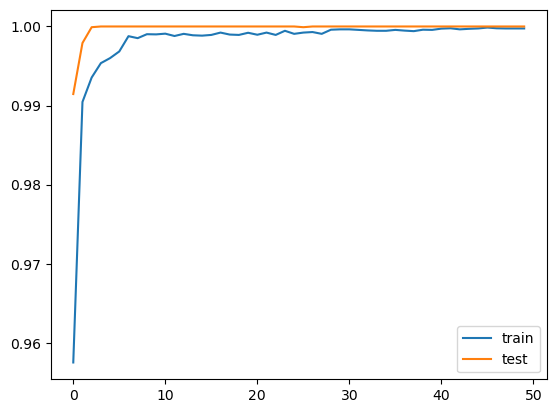

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 1. Prétraitement des données

# Ajuster la création de la colonne cible pour une classification à trois classes
df_ia['Target'] = df_ia['MidPrice'].diff()
df_ia['Target'] = df_ia['Target'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Sélection des features
features = [ 'BestBidPrice','BestBidQuantity','BestAskPrice','BestAskQuantity',
    'Spread', 'SpreadPercent', 'MidPrice', 'Imbalance','VolumeImbalance',
    'LogReturn', 'PriceVolatility', 'HistoricalVolatility', 'PriceMomentum', 'ROC',
    'RollingSTD_10', 'PriceDeltaPercent', 'EMA_20', 'RSI', 'MACD_Signal', 'CumulativeOrderFlow']


X = df_ia[features]
y = df_ia['Target']


# 2. Séparer les données en ensembles d'entraînement et de test
# 2. Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normaliser les features en ajustant le scaler uniquement sur les données d'entraînement
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_encoded = to_categorical(y_train + 1)
y_test_encoded = to_categorical(y_test + 1)
# 3. Création du modèle

def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_nn_model(len(features))

# 4. Entraîner le modèle
history = model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_encoded))

# 5. Évaluation et affichage des résultats
loss, accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Si vous souhaitez visualiser la courbe d'apprentissage
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [90]:
print(df_ia['Target'].value_counts(normalize=True))


 0    0.958494
-1    0.022225
 1    0.019281
Name: Target, dtype: float64


344/344 [==============================] - 1s 1ms/step


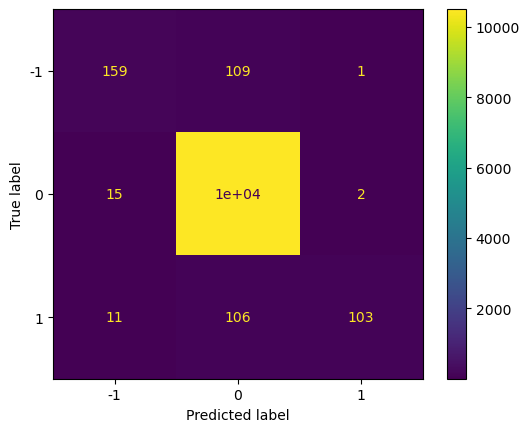

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prédire les classes pour l'ensemble de test
y_pred = model.predict(X_test_scaled)
y_pred_classes = y_pred.argmax(axis=1) - 1 # Soustraire 1 pour revenir à -1, 0, 1

# Créer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Afficher la matrice de confusion
cmd = ConfusionMatrixDisplay(cm, display_labels=['-1', '0', '1'])
cmd.plot()
plt.show()


In [93]:
# Predict the classes on the test set
predicted_probs = model.predict(X_test_scaled)
predicted_labels = predicted_probs.argmax(axis=1) - 1  # Convert back from (0, 1, 2) to (-1, 0, 1)

344/344 [==============================] - 1s 1ms/step


array([[2.22965349e-02, 9.77703393e-01, 8.97338523e-08],
       [1.64011810e-02, 9.74627495e-01, 8.97134934e-03],
       [1.63995475e-02, 9.74635541e-01, 8.96489341e-03],
       ...,
       [3.24052979e-10, 9.88580406e-01, 1.14195654e-02],
       [1.38967605e-02, 9.84549642e-01, 1.55362941e-03],
       [5.95048733e-10, 9.89013851e-01, 1.09861754e-02]], dtype=float32)

In [100]:
def backtest_strategy_corrected(signals, prices, initial_capital=100000000):
    capital = initial_capital
    position = 0  # Number of assets held
    capital_over_time = [initial_capital]

    for i in range(len(signals)):
        if signals[i] == 1 and capital >= prices[i]:  # Buy
            # Calculate the number of assets that can be bought with the current capital
            num_assets_bought = capital // prices[i]
            capital -= num_assets_bought * prices[i]
            position += num_assets_bought
        elif signals[i] == -1 and position > 0:  # Sell
            capital += position * prices[i]
            position = 0

        # Update capital taking into account the change in asset price
        if i > 0:
            capital += position * (prices[i] - prices[i-1])
        capital_over_time.append(capital)

    return capital_over_time

# Assuming df_ia and predicted_labels are defined outside of this code snippet
# Uncommenting the below lines as they rely on external variables
# test_prices = df_ia['MidPrice'].iloc[-len(predicted_labels):].values  # Corresponding prices for the test set
# capital_over_time_corrected = backtest_strategy_corrected(predicted_labels, test_prices)




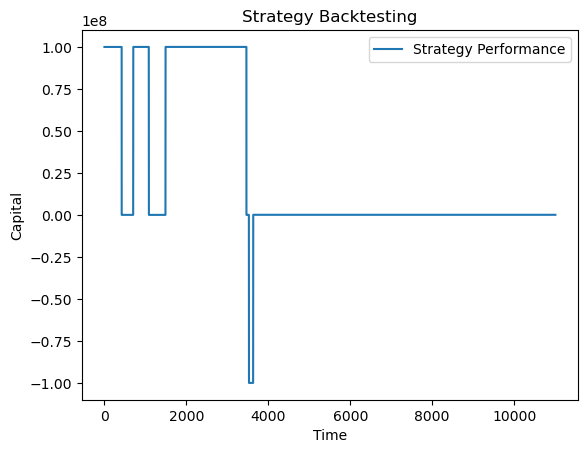

In [101]:
import matplotlib.pyplot as plt

plt.plot(capital_over_time, label='Strategy Performance')
plt.xlabel('Time')
plt.ylabel('Capital')
plt.title('Strategy Backtesting')
plt.legend()
plt.show()
